# Лабораторная работа №7.
##  Рекуррентные нейронные сети для анализа текста


### Данные
Набор данных для предсказания оценок для отзывов, собранных с сайта imdb.com, который состоит из 50,000 отзывов в виде текстовых файлов.
Отзывы разделены на положительные (25,000) и отрицательные (25,000). 
Данные предварительно токенизированы по принципу “мешка слов”, индексы слов можно взять из словаря (imdb.vocab). 
Обучающая выборка включает в себя 12,500 положительных и 12,500 отрицательных отзывов, контрольная выборка также содержит 12,500 положительных и 12,500 отрицательных отзывов, а также. 
Данные можно скачать по ссылке https://ai.stanford.edu/~amaas/data/sentiment/


### Задания
- [x] Загрузите данные. Преобразуйте текстовые файлы во внутренние структуры данных, которые используют индексы вместо слов.
- [x] Реализуйте и обучите двунаправленную рекуррентную сеть (LSTM или GRU). Какого качества классификации удалось достичь?
- [x] Используйте индексы слов и их различное внутреннее представление (word2vec, glove). Как влияет данное преобразование на качество классификации?
- [x] Поэкспериментируйте со структурой сети (добавьте больше рекуррентных, полносвязных или сверточных слоев). Как это повлияло на качество классификации?
- [ ] Используйте предобученную рекуррентную нейронную сеть (например, DeepMoji или что-то подобное).

In [0]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -O aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

--2020-05-16 13:33:18--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  22.2MB/s    in 4.6s    

2020-05-16 13:33:23 (17.4 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [1]:
import os

import warnings
warnings.filterwarnings('ignore')

import itertools
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import keras as K
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
# Data pathes
data_dir = Path('/content/aclImdb')

train_dir = data_dir / 'train'
test_dir = data_dir / 'test'


def load_data(dataset_dir):
    texts, labels = [], []
    for label_type in ('pos', 'neg'):
        dir_name = dataset_dir / label_type
        for name in os.listdir(dir_name):
            with open(dir_name / name) as f:
                texts.append(f.read())
            labels.append(int(label_type == 'pos'))

    return texts, np.array(labels)

In [4]:
# Load texts and labels
train_texts, train_labels = load_data(train_dir)
test_texts, test_labels = load_data(test_dir)

FileNotFoundError: ignored

In [0]:
max_features = 10_000
max_len = 200

# Tokenize text
tokenizer = K.preprocessing.text.Tokenizer(num_words=max_features)

AttributeError: ignored

In [0]:
# Fit test & train
tokenizer.fit_on_texts(train_texts)
tokenizer.fit_on_texts(test_texts)

In [0]:
# To sequences
train_seqiences = tokenizer.texts_to_sequences(train_texts)
test_seqiences = tokenizer.texts_to_sequences(test_texts)

In [0]:
# Train X, Y
train_X = K.preprocessing.sequence.pad_sequences(train_seqiences, maxlen=max_len)
train_Y = train_labels

# Shufle 
N = len(train_Y)
idx = np.arange(N)
train_X, train_Y = train_X[idx], train_Y[idx]

print('Train X: shape', train_X.shape)

Train X: shape (25000, 200)


In [0]:
# Test X, Y
test_X = K.preprocessing.sequence.pad_sequences(test_seqiences, maxlen=max_len)
test_Y = test_labels
print('Test  X: shape', test_X.shape)

Test  X: shape (25000, 200)


### Embedding

In [0]:
emb_model = K.models.Sequential([
    K.layers.Embedding(max_features, 128, input_length=max_len),
    K.layers.Flatten(),
    K.layers.Dense(1, activation='sigmoid'),
])

emb_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25601     
Total params: 1,305,601
Trainable params: 1,305,601
Non-trainable params: 0
_________________________________________________________________


In [0]:
emb_model.compile(
    optimizer='rmsprop', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

emb_history = emb_model.fit(
    train_X, train_Y, 
    epochs=10,
    validation_data=(test_X, test_Y),
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 15s 601us/step - loss: 0.4053 - accuracy: 0.8098 - val_loss: 0.2848 - val_accuracy: 0.8772
Epoch 2/10
25000/25000 [==============================] - 14s 576us/step - loss: 0.1824 - accuracy: 0.9300 - val_loss: 0.2817 - val_accuracy: 0.8822
Epoch 3/10
25000/25000 [==============================] - 14s 575us/step - loss: 0.0776 - accuracy: 0.9784 - val_loss: 0.3084 - val_accuracy: 0.8745
Epoch 4/10
25000/25000 [==============================] - 14s 565us/step - loss: 0.0229 - accuracy: 0.9954 - val_loss: 0.3618 - val_accuracy: 0.8689
Epoch 5/10
25000/25000 [==============================] - 14s 566us/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.4195 - val_accuracy: 0.8684
Epoch 6/10
25000/25000 [==============================] - 14s 572us/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.4859 - val_accuracy: 0.8658
Epoch 7/10
25000/25000 [==============================] 

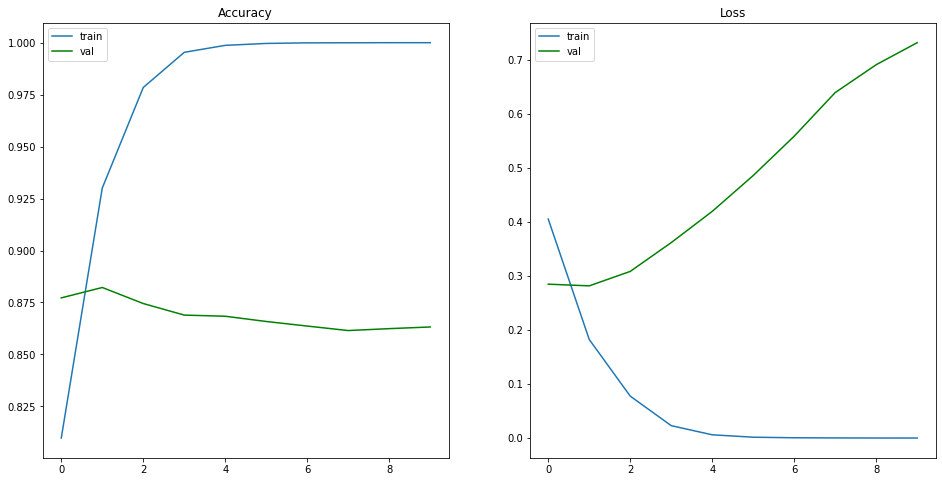

In [0]:
def plot_history(history):
    _, ax = plt.subplots(1, 2, figsize= (16, 8))

    ax[0].set_title('Accuracy')
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'], color='green')
    ax[0].legend(['train', 'val'], loc='best')

    ax[1].set_title('Loss')
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'], color='green')
    ax[1].legend(['train', 'val'], loc='best')


plot_history(emb_history)

In [0]:
emb_model.save_weights('/content/models/model_05_emd_000.h5')

### Embedding + LSTM

In [0]:
lstm_model = K.models.Sequential([
    K.layers.Embedding(max_features, 128, input_length=max_len),
    K.layers.LSTM(16),
    K.layers.Dense(1, activation='sigmoid'),
])

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,289,297
Trainable params: 1,289,297
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm_model.compile(
    optimizer='rmsprop', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

lstm_history = lstm_model.fit(
    train_X, train_Y, 
    epochs=10,
    validation_data=(test_X, test_Y),
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 99s 4ms/step - loss: 0.3981 - accuracy: 0.8270 - val_loss: 0.4614 - val_accuracy: 0.8100
Epoch 2/10
25000/25000 [==============================] - 98s 4ms/step - loss: 0.2607 - accuracy: 0.8991 - val_loss: 0.3267 - val_accuracy: 0.8709
Epoch 3/10
25000/25000 [==============================] - 98s 4ms/step - loss: 0.2235 - accuracy: 0.9147 - val_loss: 0.3167 - val_accuracy: 0.8782
Epoch 4/10
25000/25000 [==============================] - 98s 4ms/step - loss: 0.1955 - accuracy: 0.9269 - val_loss: 0.3133 - val_accuracy: 0.8810
Epoch 5/10
25000/25000 [==============================] - 97s 4ms/step - loss: 0.1734 - accuracy: 0.9370 - val_loss: 0.3012 - val_accuracy: 0.8780
Epoch 6/10
25000/25000 [==============================] - 98s 4ms/step - loss: 0.1546 - accuracy: 0.9440 - val_loss: 0.3761 - val_accuracy: 0.8690
Epoch 7/10
25000/25000 [==============================] - 100s 4ms/s

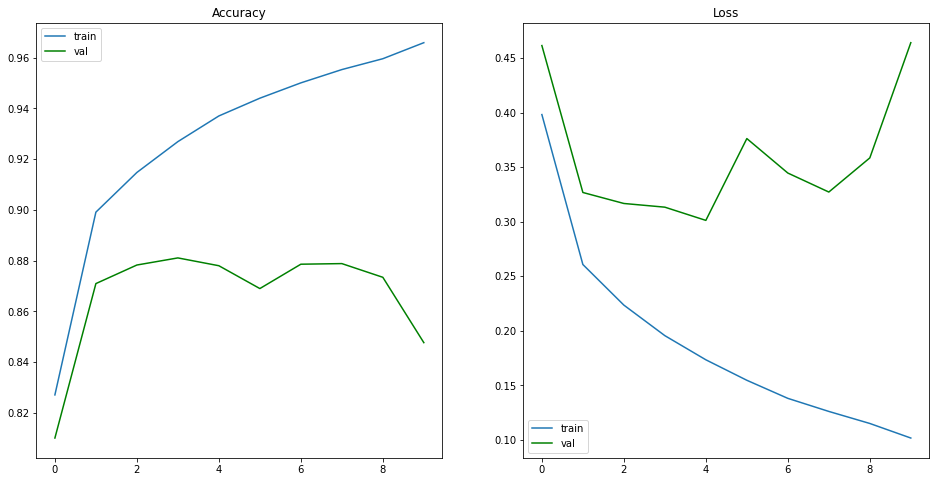

In [0]:
plot_history(lstm_history)

In [0]:
# model.save_weights('data/models/model_05_lstm_000.h5')

### Embedding + Bidirectional LSTM 

In [0]:
bilstm_model = K.models.Sequential([
    K.layers.Embedding(max_features, 128, input_length=max_len),
    K.layers.Bidirectional(K.layers.LSTM(16)),
    K.layers.Dense(1, activation='sigmoid'),
])

bilstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,298,593
Trainable params: 1,298,593
Non-trainable params: 0
_________________________________________________________________


In [0]:
bilstm_model.compile(
    optimizer='rmsprop', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

bilstm_history = bilstm_model.fit(
    train_X, train_Y, 
    epochs=10,
    validation_data=(test_X, test_Y)
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 145s 6ms/step - loss: 0.4042 - accuracy: 0.8226 - val_loss: 0.3028 - val_accuracy: 0.8730
Epoch 2/10
25000/25000 [==============================] - 151s 6ms/step - loss: 0.2590 - accuracy: 0.8984 - val_loss: 0.3052 - val_accuracy: 0.8725
Epoch 3/10
25000/25000 [==============================] - 148s 6ms/step - loss: 0.2107 - accuracy: 0.9174 - val_loss: 0.3233 - val_accuracy: 0.8803
Epoch 4/10
25000/25000 [==============================] - 149s 6ms/step - loss: 0.1778 - accuracy: 0.9330 - val_loss: 0.3061 - val_accuracy: 0.8724
Epoch 5/10
25000/25000 [==============================] - 150s 6ms/step - loss: 0.1474 - accuracy: 0.9458 - val_loss: 0.3765 - val_accuracy: 0.8388
Epoch 6/10
25000/25000 [==============================] - 152s 6ms/step - loss: 0.1225 - accuracy: 0.9553 - val_loss: 0.3548 - val_accuracy: 0.8784
Epoch 7/10
25000/25000 [==============================] - 149s

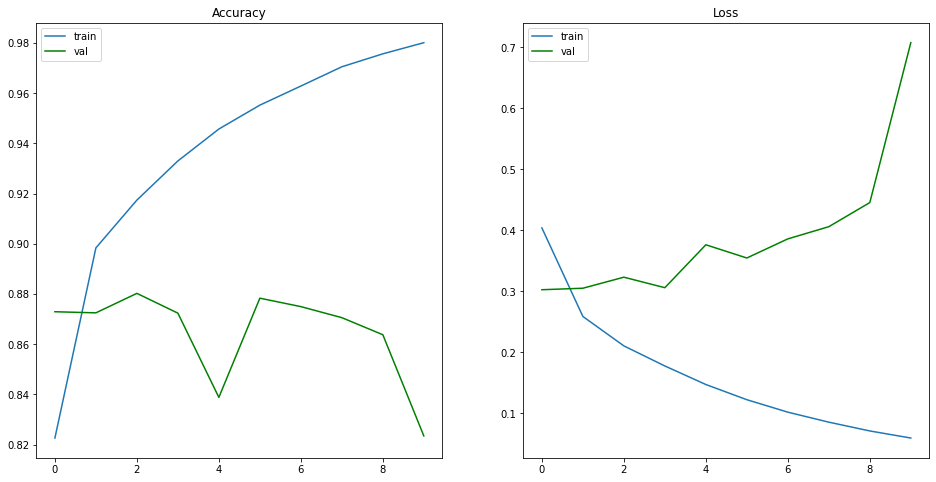

In [0]:
plot_history(bilstm_history)

In [0]:
# model.save_weights('data/models/model_05_bilstm_000.h5')

### Glove

In [0]:
# Load glove.6B.200d.txt
embeddings_index = {}
with open('/content/glove.6B.200d.txt') as f:
    for line in f:
        word, *vector = line.split()
        embeddings_index[word] = np.array(vector, dtype='float32')

In [0]:
# Embedding matrix
max_features = 10_000
max_len = 200
emb_len = 200

index_word_items = sorted(tokenizer.index_word.items())
index_word_items = itertools.islice(index_word_items, max_features-1)

embedding_matrix = np.zeros((max_features, emb_len))
for index, word in index_word_items:
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[index] = vector

In [0]:
glove_model = K.models.Sequential([
  K.layers.Embedding(max_features, emb_len, input_length=max_len),
  K.layers.Bidirectional(K.layers.LSTM(128)),
  K.layers.Dense(1, activation='sigmoid'),
])

glove_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 200)          2000000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 2,337,153
Trainable params: 2,337,153
Non-trainable params: 0
_________________________________________________________________


In [0]:
glove_model.compile(
  optimizer='rmsprop', 
  loss='binary_crossentropy',
  metrics=['acc'])

history = glove_model.fit(
  train_X, train_Y, epochs=10, 
  validation_data=(test_X, test_Y))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 722s 29ms/step - loss: 0.4151 - acc: 0.8154 - val_loss: 0.3666 - val_acc: 0.8591
Epoch 2/10
25000/25000 [==============================] - 725s 29ms/step - loss: 0.2740 - acc: 0.8912 - val_loss: 0.4415 - val_acc: 0.8477
Epoch 3/10
25000/25000 [==============================] - 727s 29ms/step - loss: 0.2240 - acc: 0.9138 - val_loss: 0.3609 - val_acc: 0.8693
Epoch 4/10
25000/25000 [==============================] - 722s 29ms/step - loss: 0.1869 - acc: 0.9297 - val_loss: 0.2870 - val_acc: 0.8871
Epoch 5/10
25000/25000 [==============================] - 719s 29ms/step - loss: 0.1558 - acc: 0.9426 - val_loss: 0.3121 - val_acc: 0.8869
Epoch 6/10
25000/25000 [==============================] - 719s 29ms/step - loss: 0.1229 - acc: 0.9552 - val_loss: 0.3528 - val_acc: 0.8796
Epoch 7/10
25000/25000 [==============================] - 728s 29ms/step - loss: 0.0937 - acc: 0.9678 - val_loss: 0.

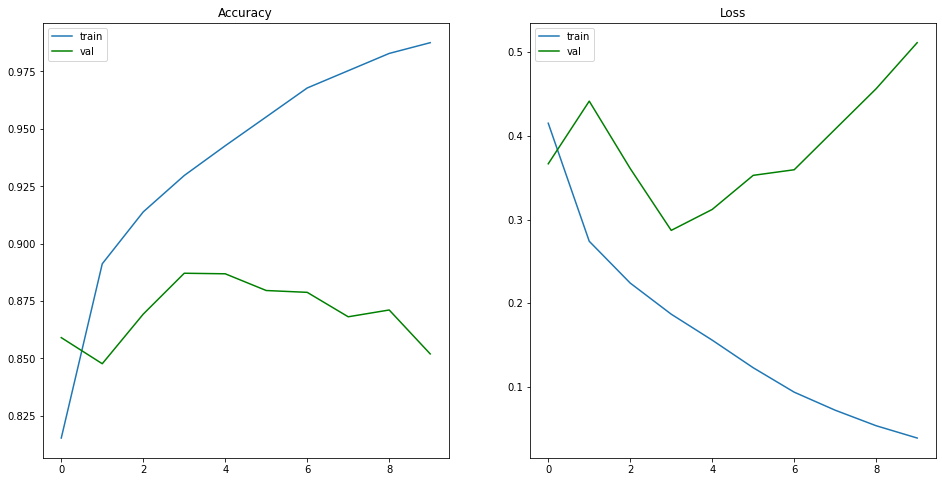

In [0]:
def plot_history(history):
    _, ax = plt.subplots(1, 2, figsize= (16, 8))

    ax[0].set_title('Accuracy')
    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'], color='green')
    ax[0].legend(['train', 'val'], loc='best')

    ax[1].set_title('Loss')
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'], color='green')
    ax[1].legend(['train', 'val'], loc='best')


plot_history(history)

In [0]:
### DeepMoji

In [5]:
!git clone https://github.com/bfelbo/DeepMoji

Cloning into 'DeepMoji'...
remote: Enumerating objects: 281, done.
remote: Total 281 (delta 0), reused 0 (delta 0), pack-reused 281
Receiving objects: 100% (281/281), 110.54 MiB | 27.11 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Checking out files: 100% (66/66), done.


In [10]:
!cd /content/DeepMoji && pip install .

Processing /content/DeepMoji
  Created wheel for deepmoji: filename=deepmoji-1.0-cp36-none-any.whl size=31384 sha256=2b08556cc935a70503bac2b2caa2cd82dc4e7452fec7a503d7c406e5eb52ab02
  Stored in directory: /tmp/pip-ephem-wheel-cache-wlg0wt7w/wheels/bc/3e/f4/7b9a156ebd8396a15709d097e944926b8028b193119529dceb
Successfully built deepmoji
  Found existing installation: deepmoji 1.0
    Uninstalling deepmoji-1.0:
      Successfully uninstalled deepmoji-1.0


In [7]:
!wget https://www.dropbox.com/s/xqarafsl6a8f9ny/deepmoji_weights.hdf5?dl=0 -O /content/deepmoji_weights.hdf5

--2020-05-16 22:15:21--  https://www.dropbox.com/s/xqarafsl6a8f9ny/deepmoji_weights.hdf5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xqarafsl6a8f9ny/deepmoji_weights.hdf5 [following]
--2020-05-16 22:15:21--  https://www.dropbox.com/s/raw/xqarafsl6a8f9ny/deepmoji_weights.hdf5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc965a4b895ed812c61e8a89d089.dl.dropboxusercontent.com/cd/0/inline/A30jqqjQJ7TvKaGf8HSwGIBvd3Cn5acDT4pPUiFH4OXqVbMYSeuGNmc31keC7RbCBXeB8O3NdTZ3OLahRczWDTih0OITboqNiXayXMyW31DVGw/file# [following]
--2020-05-16 22:15:22--  https://uc965a4b895ed812c61e8a89d089.dl.dropboxusercontent.com/cd/0/inline/A30jqqjQJ7TvKaGf8HSwGIBvd3Cn5acDT4pPUiFH4OXqVbMYSeuGNmc31keC7RbCBXeB8O3NdTZ3OLahRczWDTih0OITboqNiXay

In [11]:
from deepmoji import model_def

ModuleNotFoundError: ignored

In [9]:
max_len = 200

deepmoji_model = model_def.deepmoji_transfer(
    nb_classes=2, 
    maxlen=max_len, 
    weight_path='/content/deepmoji_weights.hdf5')

NameError: ignored